# SCOP Class Prediction using Machine learning

This notebook is an example of a workflow for a simple machine learning problem. In particular, we will be looking at protein classification according to SCOP<sup>1</sup> class.

The problem is formulated as a binary classification problem, in which we ask whether a template protein is from the same SCOP classification as the target protein.

In the dataset provided, each sample has 8 pairwise sequence-based features between the target and template proteins.

1. Murzin A. G., Brenner S. E., Hubbard T., Chothia C. (1995). SCOP: a structural classification of proteins database for the investigation of sequences and structures. J. Mol. Biol. 247, 536-540

## Imports

* numpy: Matrix algebra and numerical methods.
* pandas: Data frames for manipulating and visualising data as tables.
* matplotlib: Everybody's favourite Python plotting library.
* seaborn: Statistical visualisation library built on matplotlib and pandas. Lots of high-level functions for data visualisation.
* scikit-learn (sklearn): Machine learning library. Today we'll use its implementations of logistic regression and random forest.
* plotting: python file containing helping functions for plotting graphs.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

import plotting

sns.set(context='notebook', style='white', font_scale=1.8)

In [2]:
%matplotlib inline

# Data exploration

We read our data straight into a dataframe using Pandas. Jupyter renders dataframes as nice tables, allowing us to look at our data as soon as we load it.

In [3]:
all_data = pd.read_csv('./data/Data_ISMB2019.txt', sep=' ')
all_data.dropna(axis='index', how='any', inplace=True)

The data has 8 pairwise features between the template and the target protein and a label.

* Target_Length: Length of target sequence
* Template_Length: Length of template sequence
* Contact_PPV: % of predicted contacts (using metaPSICOV) for the target present in the template
* Contact_TP: # of predicted contacts for the target present in the template
* Contact_P: # of predicted contacts for the target successfully mapped to the template
* Contact_All: # of predicted contacts for the target.
* Neff: # of Effective Sequences
* SeqID: Sequence Identity (calculated from the NW sequence alignment)
* Label: Fam (same family), SFam (same superfamily), Fold (same fold), Random

In [4]:
all_data.head()

,Target,Template,Target_Length,Template_Length,Contact_PPV,Contact_TP,Contact_P,Contact_All,Neff,SeqID,Label
0,d12asa_,d1yfsa2,328,237,4.65,2,43,101,2676,0.177,Fam
1,d12asa_,d1eova2,328,354,22.99,20,87,101,2676,0.223,Fam
2,d12asa_,d1b8aa2,328,336,22.22,20,90,101,2676,0.220,Fam
3,d12asa_,d1l0wa3,328,357,20.00,17,85,101,2676,0.235,Fam
4,d12asa_,d1z7ma1,328,312,1.27,1,79,101,2676,0.211,Fam


In [5]:
split = pd.read_csv('./data/Data_Split.txt', sep=' ', header=None)
split.columns = ['Protein', 'Split']

# Select target-template pairs where both proteins belong to the 'same family' cluster
targets = split[split['Split']=='FAMILY']['Protein']
data = all_data[(all_data['Target'].isin(targets)) & (all_data['Template'].isin(targets))].copy()

# Drop duplicated rows since we don't know which entry is correct

# 
duplicate_idx = data.duplicated(subset=['Template', 'Target'], keep=False)
duplicates = data.loc[duplicate_idx].sort_values(by=['Target', 'Template'])

# 
data.drop_duplicates(subset=['Template', 'Target'], keep=False, inplace=True)

Many of the plotting functions available through seaborn can operate directly on a pandas dataframe and use the row and column names to automatically annotate the plot. This is a very powerful way to rapidly visualise data during the exploration stage. Here we create a bar plot of the number of examples of each class in the data set, as data imbalance is an important consideration when training and testing a classifier.

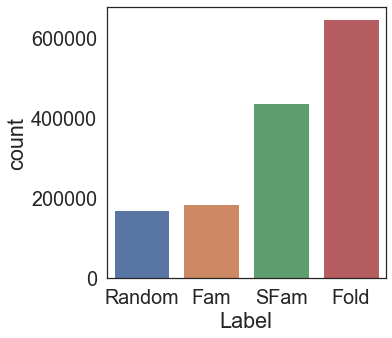

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.countplot(data=data, x='Label', order=['Random', 'Fam', 'SFam', 'Fold'], ax=ax);
#fig.savefig('bars.pdf', dpi=300)

We're going to focus on the toy problem of distinguishing between proteins that are in the same family and proteins that are completely unrelated. It's worth noting that pandas is not always clear about whether or not it is returning a view or a copy of the contents of a dataframe, so I'm explicitly creating a copy of the subset of the data we want. This lets us play with the data without modifying the original dataframe. In an interactive environment like Jupyter it pays to be careful when manipulating data and carefully document any changes made, as we want to take advatage of the ability to modify individual cells without re-running the entire notebook every time we make a change.

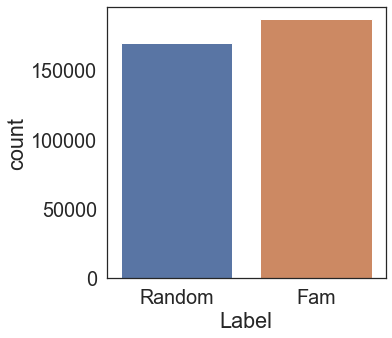

In [7]:
family_data = data[data['Label'].isin(['Fam', 'Random'])].copy()

fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.countplot(data=family_data, x='Label', order=['Random', 'Fam'], ax=ax);

# Training-test split

As our visualisation shows, the data set we'll be using has a good balance of examples of proteins from the same families and proteins that are unrelated, so we don't need to worry about data imbalance here. As in any machine learning project, it's important that we decide on our test set before going any further. We adopt an 80/20 split, using 80% of the data for training and reserving 20% for testing. For the workshop we're also using a subset of 5000 randomly-chosen proteins just to speed up model training. For this problem, we're splitting the data *by target* rather than simply splitting the examples to ensures that all examples for a target are in the same set.

Also, for reproducibility, we set the seed for our random number generator.

In [8]:
np.random.seed(42)
n_samples = 5000

sample = np.random.choice(family_data['Target'].unique(), size=n_samples, replace=False)

n_train = int(0.8*n_samples)
n_test = int(0.2*n_samples)

train = sample[:n_train]
test = sample[n_train:]

In [9]:
feature_names = ['Target_Length', 'Template_Length', 'Contact_PPV', 'Contact_TP', 'Contact_P', 'Contact_All', 'Neff', 'SeqID']

train_idx = family_data['Target'].isin(train)
test_idx = family_data['Target'].isin(test)

X_train = family_data[train_idx][feature_names].values
X_test = family_data[test_idx][feature_names].values

y_train = family_data[train_idx]['Label'].replace({'Random': 0, 'Fam': 1}).values
y_test = family_data[test_idx]['Label'].replace({'Random': 0, 'Fam': 1}).values

Confirm that our training and test sets all have a similar balance of positive and negative examples.

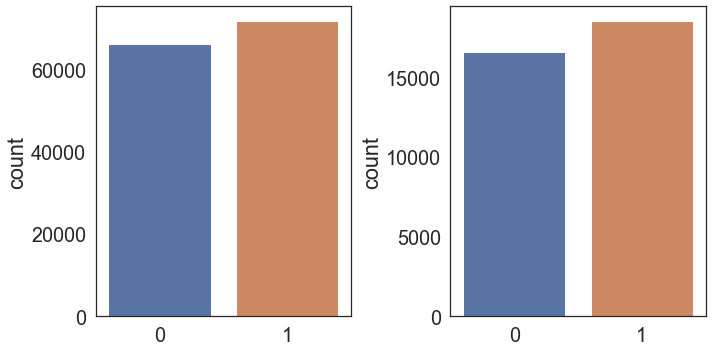

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x=y_train, ax=axes[0])
sns.countplot(x=y_test, ax=axes[1])
fig.tight_layout()

# Training a random forest classifier

In [11]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [12]:
print(f'Accuracy score: {rf.score(X_test, y_test):.3f}')

Accuracy score: 0.880


# Visualising the results

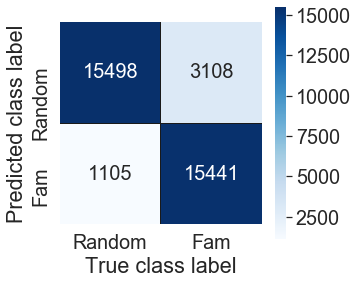

In [13]:
predicted = rf.predict(X_test)
test_probs = rf.predict_proba(X_test)[:,1]

fig, ax = plt.subplots(figsize=(5,5))
plotting.draw_confusion_matrix(y_test, predicted, class_labels={0: 'Random', 1: 'Fam'}, ax=ax)
fig.tight_layout()
#fig.savefig('rf_confusion_matrix.png', dpi=300)

# Training another machine learning algorithm - Logistic regression

In [14]:
logistic = LogisticRegression(C=1e5, random_state=42, solver='liblinear')
logistic.fit(X_train, y_train)
logistic_test_probs = logistic.predict_proba(X_test)[:,1]

print(f'Accuracy score: {logistic.score(X_test, y_test):.3f}')

Accuracy score: 0.848


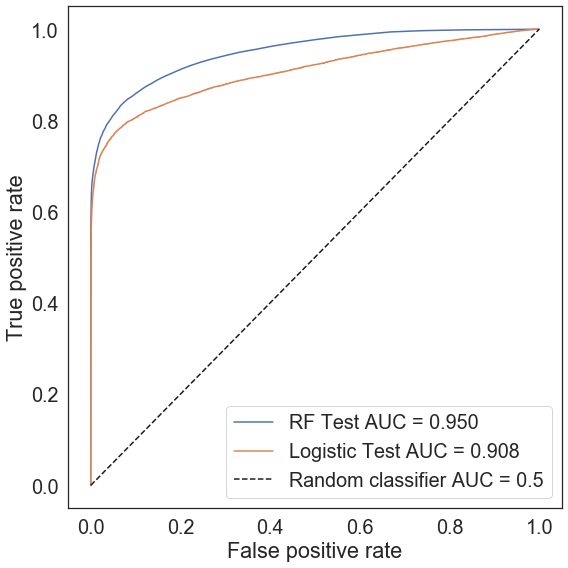

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
plotting.draw_roc_curve(y_test, test_probs, name='RF Test', ax=ax)
plotting.draw_roc_curve(y_test, logistic_test_probs, name='Logistic Test', ax=ax)

ax.plot([0,1],[0,1], 'k--', label='Random classifier AUC = 0.5')
ax.legend(loc='best')
fig.tight_layout()

#fig.savefig('roc_curve.png', dpi=300)

Frequently scaling of variables is important in machine learning projects (beyond the scope of this workshop). Let's see how logistic regression performs once we've scaled our variables.

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

logistic.fit(X_train_scaled, y_train)
logistic_test_probs_scaled = logistic.predict_proba(X_test_scaled)[:,1]

print(f'Accuracy score: {logistic.score(X_test_scaled, y_test):.3f}')

Accuracy score: 0.856


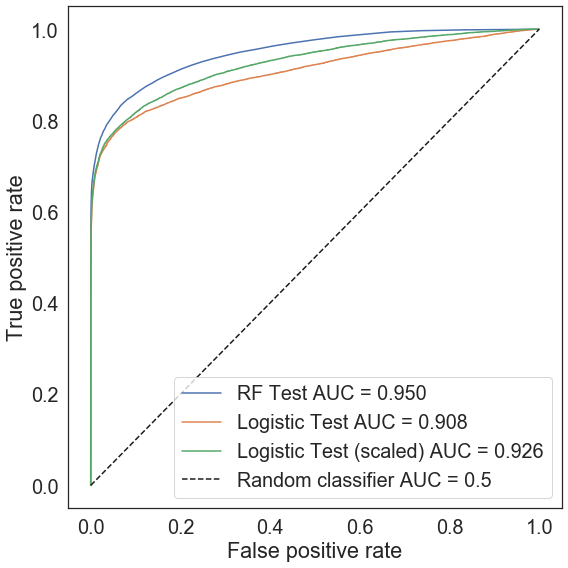

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
plotting.draw_roc_curve(y_test, test_probs, name='RF Test', ax=ax)
plotting.draw_roc_curve(y_test, logistic_test_probs, name='Logistic Test', ax=ax)
plotting.draw_roc_curve(y_test, logistic_test_probs_scaled, name='Logistic Test (scaled)', ax=ax)

ax.plot([0,1],[0,1], 'k--', label='Random classifier AUC = 0.5')
ax.legend(loc='best')
fig.tight_layout()

#fig.savefig('roc_curve.png', dpi=300)

# Extensions

This notebook is just scratching the surface of the problem at hand. If you are interested, there are many possible ways to extend this work. For example:
* Try other machine learning methods (e.g. [simple neural network](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier))
* Analyse results further (e.g. are we better at predicting short proteins or long proteins?)
* Analyse [feature importance](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_)